# FER Classifier
1. Develop the Classifier Model
2. Train the Model with FER 2013 training data
3. Append the training data with GAN generated images
4. Train the model with GAN generated image

## Import Libraries
- cv2 for image processing
- os for general read/write
- matplotlib for plots

In [36]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

### Read an image and display

In [37]:
img_array = cv2.imread("../datasets/FER_2013/train/angry/Training_3908.jpg")

In [38]:
img_array.shape

(48, 48, 3)

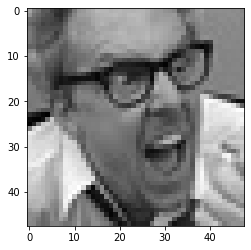

In [39]:
plt.imshow(img_array)

## Set the data directory and test data directory

In [40]:
data_dir = "../datasets/FER_2013/train/"
test_data_dir = "../datasets/FER_2013/test/"

## Set the labels for classification

In [41]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

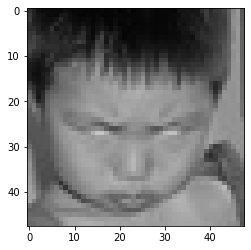

In [42]:
for category in classes:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

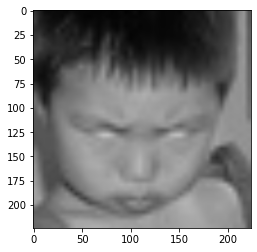

In [43]:
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
new_array.shape

(224, 224, 3)

## Create training data
1. Read data from the data directory
2. Append the label based on the type of image
3. Resize the image to 224 x 224

In [10]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array,(img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e: 
                pass

In [11]:
create_training_data()
print(len(training_data))

28709


## Create test data
1. Read data from the data directory
2. Append the label based on the type of image
3. Resize the image to 224 x 224

In [142]:
test_data = []

def create_test_data():
    for category in classes:
        path = os.path.join(test_data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array,(img_size, img_size))
                test_data.append([new_array, class_num])
            except Exception as e: 
                pass
    

In [143]:
create_test_data()
print(len(test_data))

7178


## Shuffle the training data

In [14]:
import random
random.shuffle(training_data)

## Prepare test data
1. For the tuples "features" and "label" in the training data:
    - add them to X and Y lists
    - Reshape the features in X and convert it to an np array
2. For the tuples "features" and "label" in the test data:
    - add them to test_images and test_labels lists
    - Reshape the features in X and convert it to an np array

In [62]:
x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, img_size, img_size, 3)

test_images = []
test_labels = []
for features, label in test_data:
    test_images.append(features)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 3)


In [63]:
x.shape
test_images.shape

(7178, 224, 224, 3)

## Normalize the features array by dividing by 255

In [17]:
x = x/255.0

In [64]:
y = np.array(y)
test_labels = np.array(test_labels)

In [65]:
test_labels.shape

(7178,)

## Convert the labels to categorical

In [20]:
from keras.utils import to_categorical
y = to_categorical(y)
test_labels = to_categorical(test_labels)

In [21]:
y[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

## Start creating the Model from scratch

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

## Create the Initiak Model

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history = model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

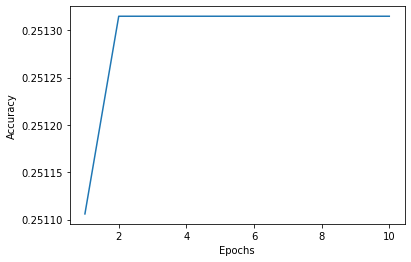

In [41]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [24]:
model.summary()
model.save('initial_1.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 224)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

# Scaling up the model 

In [24]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [25]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [28]:
scaled_model = keras.Model(inputs = base_input, outputs = final_output)
scaled_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [31]:
scaled_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = scaled_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 4084s 5s/step - loss: 1.7280 - accuracy: 0.2995 - val_loss: 120.6911 - val_accuracy: 0.2816
Epoch 2/10
898/898 [==============================] - 4153s 5s/step - loss: 1.5279 - accuracy: 0.4040 - val_loss: 80.8776 - val_accuracy: 0.3651
Epoch 3/10
898/898 [==============================] - 4059s 5s/step - loss: 1.3783 - accuracy: 0.4724 - val_loss: 97.7099 - val_accuracy: 0.3867
Epoch 4/10
898/898 [==============================] - 4152s 5s/step - loss: 1.1799 - accuracy: 0.5556 - val_loss: 158.9740 - val_accuracy: 0.3643
Epoch 5/10
898/898 [==============================] - 4097s 5s/step - loss: 0.9005 - accuracy: 0.6642 - val_loss: 288.5673 - val_accuracy: 0.3412
Epoch 6/10
898/898 [==============================] - 4232s 5s/step - loss: 0.5946 - accuracy: 0.7854 - val_loss: 405.8852 - val_accuracy: 0.3664
Epoch 7/10
898/898 [==============================] - 4193s 5s/step - loss: 0.3568 - accuracy: 0.8759 - val_loss: 662.4429 - v

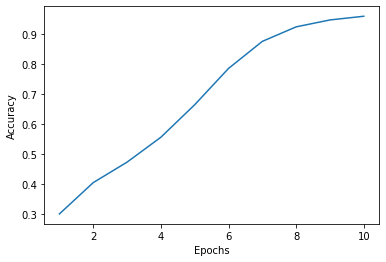

In [32]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [36]:
scaled_model.summary()
scaled_model.save('scaled_model_1.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

# Adding Dropout

In [43]:
from tensorflow.keras.layers import Dropout
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [49]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [50]:
regularized_model = keras.Model(inputs = base_input, outputs = final_output)
regularized_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [51]:
regularized_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = regularized_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 4727s 5s/step - loss: 0.2991 - accuracy: 0.8993 - val_loss: 700.1165 - val_accuracy: 0.3605
Epoch 2/10
898/898 [==============================] - 4266s 5s/step - loss: 0.1414 - accuracy: 0.9540 - val_loss: 681.2671 - val_accuracy: 0.3555
Epoch 3/10
898/898 [==============================] - 4250s 5s/step - loss: 0.1243 - accuracy: 0.9627 - val_loss: 848.1249 - val_accuracy: 0.3576
Epoch 4/10
898/898 [==============================] - 4276s 5s/step - loss: 0.1034 - accuracy: 0.9708 - val_loss: 850.7083 - val_accuracy: 0.3512
Epoch 5/10
898/898 [==============================] - 4646s 5s/step - loss: 0.0946 - accuracy: 0.9724 - val_loss: 1103.7334 - val_accuracy: 0.3068
Epoch 6/10
898/898 [==============================] - 4696s 5s/step - loss: 0.0874 - accuracy: 0.9741 - val_loss: 919.7676 - val_accuracy: 0.3500
Epoch 7/10
898/898 [==============================] - 4490s 5s/step - loss: 0.0784 - accuracy: 0.9780 - val_loss: 1109.7172

In [52]:
regularized_model.summary()
regularized_model.save('regularized_model_1.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

# Add L2 regularization

In [57]:
from keras import regularizers
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [58]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [59]:
regularized_l2_model = keras.Model(inputs = base_input, outputs = final_output)
regularized_l2_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [60]:
regularized_l2_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = regularized_l2_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 5490s 6s/step - loss: 0.2108 - accuracy: 0.9368 - val_loss: 974.7734 - val_accuracy: 0.3352
Epoch 2/10
898/898 [==============================] - 4355s 5s/step - loss: 0.0917 - accuracy: 0.9759 - val_loss: 1085.5696 - val_accuracy: 0.3395
Epoch 3/10
898/898 [==============================] - 4368s 5s/step - loss: 0.0753 - accuracy: 0.9804 - val_loss: 1016.4065 - val_accuracy: 0.3511
Epoch 4/10
898/898 [==============================] - 4368s 5s/step - loss: 0.0656 - accuracy: 0.9829 - val_loss: 1198.9519 - val_accuracy: 0.3534
Epoch 5/10
898/898 [==============================] - 4361s 5s/step - loss: 0.0675 - accuracy: 0.9821 - val_loss: 1052.3593 - val_accuracy: 0.3452
Epoch 6/10
898/898 [==============================] - 4255s 5s/step - loss: 0.0598 - accuracy: 0.9850 - val_loss: 1145.5231 - val_accuracy: 0.3502
Epoch 7/10
898/898 [==============================] - 4082s 5s/step - loss: 0.0580 - accuracy: 0.9855 - val_loss: 1060.

In [61]:
regularized_l2_model.summary()
regularized_l2_model.save('regularized_l2_model_1.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

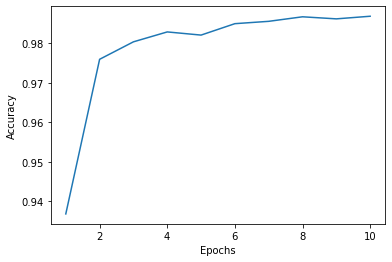

In [62]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [63]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [64]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [65]:
final_model = keras.Model(inputs = base_input, outputs = final_output)
final_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [66]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = final_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 5592s 6s/step - loss: 0.1786 - accuracy: 0.9514 - val_loss: 1221.2645 - val_accuracy: 0.3314
Epoch 2/10
898/898 [==============================] - 4328s 5s/step - loss: 0.0838 - accuracy: 0.9809 - val_loss: 1168.5475 - val_accuracy: 0.3200
Epoch 3/10
898/898 [==============================] - 4300s 5s/step - loss: 0.0794 - accuracy: 0.9825 - val_loss: 1196.0580 - val_accuracy: 0.3408
Epoch 4/10
898/898 [==============================] - 4704s 5s/step - loss: 0.0757 - accuracy: 0.9848 - val_loss: 1170.7339 - val_accuracy: 0.3374
Epoch 5/10
898/898 [==============================] - 4712s 5s/step - loss: 0.0714 - accuracy: 0.9848 - val_loss: 1286.7987 - val_accuracy: 0.3385
Epoch 6/10
898/898 [==============================] - 4703s 5s/step - loss: 0.0690 - accuracy: 0.9859 - val_loss: 1127.2917 - val_accuracy: 0.3233
Epoch 7/10
898/898 [==============================] - 4702s 5s/step - loss: 0.0649 - accuracy: 0.9866 - val_loss: 1127

In [69]:
final_model.summary()
final_model.save('final_model.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

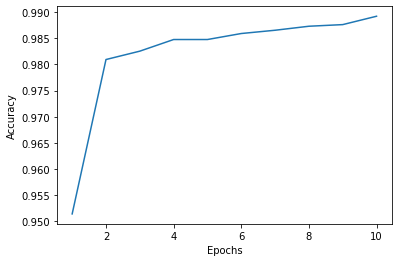

In [67]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Load Model and predict

In [152]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

In [177]:
final_model = tf.keras.models.load_model('final_model.h5')
frame = cv2.imread("images/fear_generated_img_8.png")

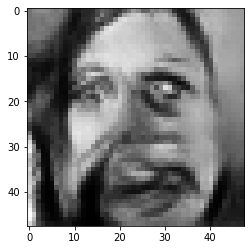

In [178]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [179]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [180]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
assert not faceCascade.empty()
faceCascade.empty()

False

In [181]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [182]:
gray.shape
type(gray[1])

numpy.ndarray

In [183]:
import numpy as np
gray = np.array(gray, dtype='uint8')
gray.dtype

dtype('uint8')

In [184]:
#faces = faceCascade.detectMultiScale(gray,1,1,4)
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(1,1),
    flags = cv2.CASCADE_SCALE_IMAGE
)
print(len(faces))
for x,y,w,h in faces:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+w), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

0


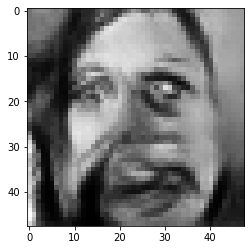

In [185]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

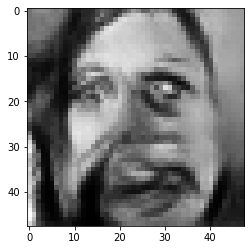

In [186]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [187]:
final_image = cv2.resize(frame, (224, 224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [188]:
print(classes)
predictions = new_model.predict(final_image)
print(classes[np.argmax(predictions[0])])
#tf.nn.softmax(predictions[0])

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
1/1 [==============================] - 0s 51ms/step
fear


# Add generated images to training

In [128]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [129]:
data_dir = 'images'
img_size = 224
training_data = []

# Directory containing the images
images_directory = 'images'

# Pattern to match filenames
#pattern = 'angry'

# List all files in the directory
file_list = os.listdir(images_directory)

# Filter files that start with the specified pattern

#read_files = [file for file in file_list if file.startswith(pattern)]

for category in classes:
    read_files = [file for file in file_list if file.startswith(category)]
    class_num = classes.index(category)
    for img in read_files:
        img_array = cv2.imread(os.path.join(images_directory, img))
        new_array = cv2.resize(img_array,(img_size, img_size))
        training_data.append([new_array, class_num])
        new_array = cv2.resize(img_array,(img_size, img_size))


In [132]:
len(training_data)

60

In [133]:
data_dir = "../datasets/FER_2013/train/"
test_data_dir = "../datasets/FER_2013/test/"

test_data = []

def create_test_date():
    for category in classes:
        path = os.path.join(test_data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            print('yes')
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array,(img_size, img_size))
                test_data.append([new_array, class_num])
            except Exception as e: 
                pass
    

In [144]:
x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, img_size, img_size, 3)

test_images = []
test_labels = []
for features, label in test_data:
    test_images.append(features)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 3)


In [145]:
import random
random.shuffle(training_data)

In [146]:
x = x/255.0

In [147]:
y = np.array(y)
test_labels = np.array(test_labels)
test_labels

array([0, 0, 0, ..., 6, 6, 6])

In [148]:
from keras.utils import to_categorical
y = to_categorical(y)
test_labels = to_categorical(test_labels)

## Load the final model 
1. Traing the final model with the new training data which includes the generated images
2. Save the model

In [149]:
final_model = tf.keras.models.load_model('final_model.h5')

In [150]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = final_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
2/2 [==============================] - 232s 224s/step - loss: 3.8457 - accuracy: 0.4000 - val_loss: 888.6248 - val_accuracy: 0.3438
Epoch 2/10
2/2 [==============================] - 228s 224s/step - loss: 2.0350 - accuracy: 0.5500 - val_loss: 785.6077 - val_accuracy: 0.3398
Epoch 3/10
2/2 [==============================] - 229s 224s/step - loss: 0.9999 - accuracy: 0.7333 - val_loss: 739.4257 - val_accuracy: 0.3222
Epoch 4/10
2/2 [==============================] - 228s 223s/step - loss: 0.6947 - accuracy: 0.8333 - val_loss: 716.2648 - val_accuracy: 0.3055
Epoch 5/10
2/2 [==============================] - 228s 224s/step - loss: 0.5286 - accuracy: 0.8500 - val_loss: 704.7239 - val_accuracy: 0.2933
Epoch 6/10
2/2 [==============================] - 228s 224s/step - loss: 0.4726 - accuracy: 0.8667 - val_loss: 698.1744 - val_accuracy: 0.2850
Epoch 7/10
2/2 [==============================] - 227s 223s/step - loss: 0.3043 - accuracy: 0.9167 - val_loss: 692.7886 - val_accuracy: 0.2782

In [151]:
final_model.save('final_gen_trained_model.h5')